In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
flood_data = pd.read_csv('aegis_flood_data/AEGISDataset.csv')

In [3]:
flood_data.info()
flood_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3510 entries, 0 to 3509
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   lat         3510 non-null   float64
 1   lon         3510 non-null   float64
 2   flood_heig  3510 non-null   int64  
 3   elevation   3510 non-null   float64
 4   precipitat  3510 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 137.2 KB


,lat,lon,flood_heig,elevation,precipitat
0,14.640394,121.055708,0,54.553295,9.0
1,14.698299,121.002132,0,21.856272,10.0
2,14.698858,121.100261,0,69.322807,16.0
3,14.571310,120.983334,0,10.987241,8.0
4,14.762232,121.075735,0,87.889847,18.0


In [4]:
# reclassify data
flood_data['is_flooding'] = flood_data['flood_heig'].apply(lambda x: 0 if x <= 1 else 1)

In [6]:
flood_data.head()

,lat,lon,flood_heig,elevation,precipitat,is_flooding
0,14.640394,121.055708,0,54.553295,9.0,0
1,14.698299,121.002132,0,21.856272,10.0,0
2,14.698858,121.100261,0,69.322807,16.0,0
3,14.571310,120.983334,0,10.987241,8.0,0
4,14.762232,121.075735,0,87.889847,18.0,0


In [7]:
flood_data['is_flooding'].value_counts()

is_flooding
1    2316
0    1194
Name: count, dtype: int64

In [24]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
# Initialize geolocator
geolocator = Nominatim(user_agent="geoapiExercises")

# Function to reverse geocode latitude and longitude
def reverse_geocode(lat, lon):
    try:
        location = geolocator.reverse((lat, lon), timeout=10)
        if location and 'city' in location.raw['address']:
            return location.raw['address'].get('city')
        elif location and 'town' in location.raw['address']:
            return location.raw['address'].get('town')
        elif location and 'village' in location.raw['address']:
            return location.raw['address'].get('village')
        else:
            return None
    except GeocoderTimedOut:
        return None

# Apply reverse geocoding to each row in the DataFrame
flood_data['city'] = flood_data.apply(lambda row: reverse_geocode(row['lat'], row['lon']), axis=1)

# Group the data by city
grouped = flood_data.groupby('city').sum()  # Example of grouping by sum (you can use count, mean, etc.)

print(grouped)

KeyboardInterrupt: 

In [ ]:
flood_data.head()

## Plotting Data

### Using Folium

In [7]:
import folium

In [17]:
m = folium.Map(location=[14.599512, 121.023415], zoom_start=11)
m

In [20]:
for _, row in flood_data.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
    ).add_to(m)

In [21]:
m

### Using Contextily

In [5]:
import geopandas as gpd
import contextily as cx

In [18]:
gdf = gpd.GeoDataFrame(flood_data, geometry=gpd.points_from_xy(flood_data['lon'], flood_data['lat']))

In [19]:
# Set CRS to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

# Convert to Web Mercator (EPSG:3857)
gdf = gdf.to_crs(epsg=3857)

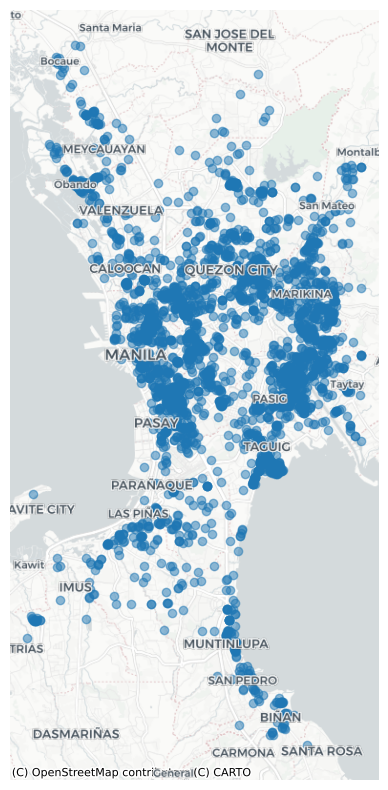

In [27]:
# Plot the data
ax = gdf.plot(figsize=(10, 10), alpha=0.5)
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.CartoDB.PositronNoLabels)
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.CartoDB.PositronOnlyLabels)
ax.set_axis_off()

### Class == 1 (Flooded)

In [6]:
flood_data_flood = flood_data[flood_data['is_flooding'] == 1]
flood_data_no_flood = flood_data[flood_data['is_flooding'] == 0]

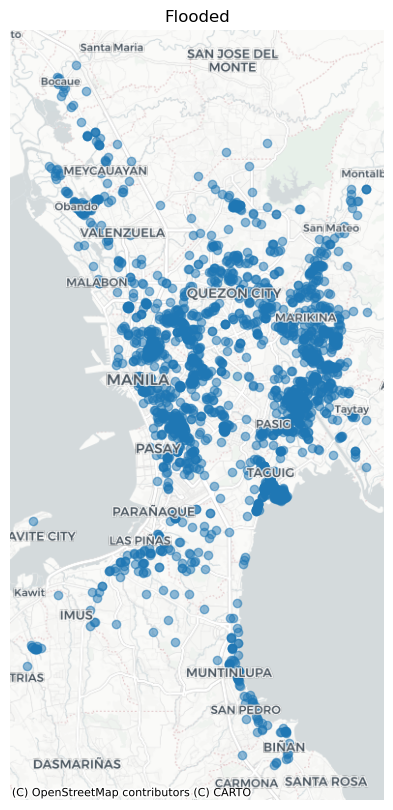

In [22]:
# plot flooded
data = flood_data_flood
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['lon'], data['lat']))
# Set CRS to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

# Convert to Web Mercator (EPSG:3857)
gdf = gdf.to_crs(epsg=3857)
ax = gdf.plot(figsize=(10, 10), alpha=0.5)
ax.set_title('Flooded')
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.CartoDB.PositronNoLabels)
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.CartoDB.PositronOnlyLabels)
ax.set_axis_off()

### Class == 0 (No Flood)

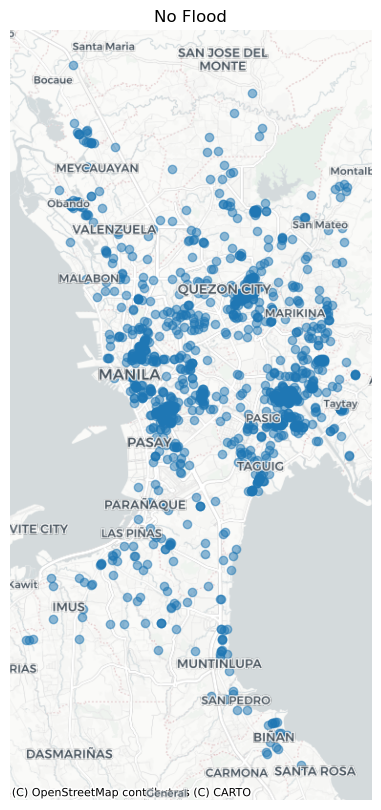

In [19]:
# plot no flood
data = flood_data_no_flood
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['lon'], data['lat']))
# Set CRS to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

# Convert to Web Mercator (EPSG:3857)
gdf = gdf.to_crs(epsg=3857)
ax = (gdf.plot(figsize=(10, 10), alpha=0.5))
ax.set_title('No Flood')
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.CartoDB.PositronNoLabels)
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.CartoDB.PositronOnlyLabels)
ax.set_axis_off()

Now, since we have the data, let's fit a spatial regression model to our data.